# Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import re
import time 
import matplotlib.pyplot as plt
from collections import Counter
import copy
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pywt

# Load the data

## Creation of the structured array

In [2]:
# Define the structured array with known column names and data types
data_types = [
    ('line_of_sight', 'U4'), 
    ('train_test', 'U5'), 
    ('device', 'U9'),
    ('make', 'U9'),
    ('model', 'U28'),
    ('activity', 'U8'),
    ('experiment', 'U2'),
    ('cwt_coeffs', 'O')
    # ,('wavelet', 'O'),
    ]
structured_array = np.empty(0, dtype=data_types)

# Function to append a row to the structured array
def add_row_to_structured_array(struct_array, **kwargs):
    new_row = np.array([tuple(
        kwargs.get(name, None) for name in struct_array.dtype.names
        )], dtype=struct_array.dtype)
    return np.append(struct_array, new_row, axis=0)

# Function to fill the array using kwargs
def fill_array(structured_array, **kwargs):
    # Directly use kwargs to construct the data dictionary
    data_to_add = [kwargs]
    
    for data in data_to_add:
        structured_array = add_row_to_structured_array(structured_array, **data)
    
    return structured_array


print(structured_array.dtype.names)
print(len(structured_array))

# # Create boolean masks for each condition
# age_25_mask = structured_array['age'] == 25
# height_6_mask = structured_array['height'] == 6.0

# # Combine the masks using the bitwise AND operator
# combined_mask = age_25_mask & height_6_mask

# # Use the boolean mask to filter the structured array
# filtered_array = structured_array[combined_mask]

# print(filtered_array)

# print(structured_array['name'])
# print(structured_array[0])

('line_of_sight', 'train_test', 'device', 'make', 'model', 'activity', 'experiment', 'cwt_coeffs')
0


## Dataset acquiring functions 

In [3]:
def get_all_metadata(filename, dirpath):
#     print(dirpath)
    file_path = os.path.join(dirpath, filename)

    # Get the make and the model
    make_model = os.path.basename(os.path.dirname(dirpath))
    make_model_split = make_model.split("_")
    make = make_model_split[0]
    if make == "BEEBEERUN":
        model = "FPV RC drone mini quadcopter"
    else:
        model = make_model_split[1]

    # Get the activity
    activity = os.path.basename(dirpath)
    # print('\tactivity:', activity)

    # Match the experiment and capture "meta" or "data"
    regex = r"_.*?(\d{1,2})\.mat_(meta|data)\.csv"
    match = re.search(regex, filename)

    # PK: Set default values for experiment and file_type
    # experiment = None
    # file_type = None

    if match:
        experiment = match.group(1)
        file_type = match.group(2)
    else:
        None
        # print("error",filename)

    # Get the device, line_of_sight and train_test
    device = os.path.basename(os.path.dirname(os.path.dirname(dirpath)))
    # print("\tdevice",device)

    # Get the line-of-sight and wether there is Train-Test split (True for Train)
    test_train = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(dirpath))))
    if test_train not in [ "Test", "Train"]:
        # we are in NLOS
        line_of_sight = test_train
        test_train = "none"
    else:
        line_of_sight = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(dirpath)))))

    # print("\tline_of_sight", line_of_sight)
    # print("\ttest_train", test_train)
    
    # print("\texperiment", type(experiment), "  |  ",file_type)
    return file_type, make, model, activity, experiment, line_of_sight, test_train, device


def load_data(path, nth_value_only=False):

    # Load the CSV file using numpy, only reading the "Data" column
    data = np.genfromtxt(path, delimiter=',', skip_header=1, usecols=[0], dtype=float)
    # Scale to get voltage
    data = data * 6.581**(-6)

    if nth_value_only:
        data = data[::nth_value_only]

    return data

# New function to extract CWT features
def extract_features(signal, wavelet='mexh', scales=np.arange(1, 51)): 
    coefficients, _ = pywt.cwt(signal, scales, wavelet)
    avg_coefficients = np.mean(np.abs(coefficients), axis=1)
    
    return avg_coefficients

# def process_signal(input_data):
#     # Calculate the Fourier Transform
#     fft = np.fft.fft(input_data)
    
#     # Calculate Power Spectral Density (PSD)
#     freqs = np.fft.fftfreq(len(input_data))
#     psd = np.abs(fft)**2 / len(input_data)

#     # Limit the Power Spectral Density to frequencies from 0 to 0.5 (needed for alignment between all datasets)
#     positive_psd = psd[(freqs >= 0) & (freqs <= 0.5)]
#     # positive_freqs = freqs[(freqs >= 0) & (freqs <= 0.5)]

# # PK
#     return positive_psd
#     # return positive_psd, positive_freqs



def iterate_folders(root_dir, structured_array, nth_value_only):
    
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.csv'):

                file_type, make, model, activity, experiment, line_of_sight, train_test, device = get_all_metadata(filename, dirpath)

                if file_type == "data":
                    # The actual data

                    print(dirpath)
                    print(f'train_test: {train_test}  |  make: {make}  |  model: {model}  |  activity: {activity}  |  experiment: {experiment}')
                    
                    tic = time.time()
                    # Load the signal
                    signal = load_data(dirpath + "/" + filename, nth_value_only)
                    # print(len(signal))

                    ############## FOURIER TRANSFORM ##############
                    # powers_fft = process_signal(signal)
                    # print('\tFFT is ready, power spectrum len:', len(powers_fft))
                    ###############################################

                    
                    # ############## Wavelet transform ##############
                    features = extract_features(signal)
                    # ###############################################

                    tac = time.time()
                    execution_time = tac - tic
                    print(f"\tExecution time: {execution_time:.4f} seconds")

                else:
                    # The metadata
                    continue
                
                ################
                # code to append all variables to the structured array
                structured_array = fill_array(
                structured_array, 
                line_of_sight = line_of_sight, 
                train_test = train_test, 
                device = device, 
                make = make, 
                model = model, 
                activity = activity, 
                experiment = experiment, 
                cwt_coeffs = features
                # ,wavelet = ...
                )
                ################

                print(f"\tNow we have {len(structured_array)} samples")
                print()

    # all_data_df = pd.concat(data_frames, ignore_index=True)

    return structured_array

## Run to get the whole dataset 

In [4]:
start = time.time()
# Get the current working directory
current_directory = os.getcwd()

# Assuming the CardRF directory is in the same folder as the current script
cardrf_directory = os.path.join(current_directory, 'data')

# Load the data
nth_value_only = False
# nth_value_only = 100

data_array = iterate_folders(cardrf_directory, structured_array, nth_value_only)
end = time.time()

print(f'Total execution time: {end - start:.2f} seconds')

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 02
	Execution time: 16.9015 seconds
	Now we have 1 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 04
	Execution time: 16.9162 seconds
	Now we have 2 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 06
	Execution time: 16.6531 seconds
	Now we have 3 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |  make: BEEBEERUN  |  model: FPV RC drone mini quadcopter  |  activity: FLYING  |  experiment: 09
	Execution time: 16.6207 seconds
	Now we have 4 samples

d:\Summer_school_case\data\LOS\Test\UAV\BEEBEERUN\FLYING
train_test: Test  |

In [5]:
def col_value_counts(array_col):
    col = array_col
    col_count = Counter(col)
    df = pd.DataFrame.from_dict(col_count, orient='index', columns=['count'])
    return df

In [6]:
make_model_activity = np.array([f"{row['make']} - {row['model']} - {row['activity']}" for row in data_array])


In [7]:
new_dtype = data_array.dtype.descr + [('make_model_activity', 'U100')]
new_data = np.zeros(data_array.shape, dtype=new_dtype)

for name in data_array.dtype.names:
    new_data[name] = data_array[name]

new_data['make_model_activity'] = make_model_activity

make_model = np.array([f"{row['make']} - {row['model']}" for row in new_data])

new_dtype = new_data.dtype.descr + [('make_model', 'U100')]
new_data = np.zeros(new_data.shape, dtype=new_dtype)

for name in data_array.dtype.names:
    new_data[name] = data_array[name]

new_data['make_model'] = make_model

df = col_value_counts(new_data['make_model'])
df

df = col_value_counts(new_data['make_model_activity'])
df = col_value_counts(new_data['make_model'])


In [8]:
# def plot_all_psd_one_type(cwt_coeffs_arrays, titles):
#     plt.figure(figsize=(10, 6))
#     for coeffs in cwt_coeffs_arrays:
#         plt.plot(coeffs, label='Signal', color='blue')
#     plt.xlabel('Scale')
#     plt.ylabel('Average CWT Coefficients')
#     plt.title(f'CWT Coefficients of the Signal\n{titles} ({len(cwt_coeffs_arrays)} samples)')
#     plt.grid(True)
#     plt.show()

# for ind in df.index:
#     print(ind)
#     mask = new_data['make_model'] == ind
#     the_array = new_data[mask]
#     cwt_coeffs_arrays = the_array['cwt_coeffs']
#     plot_all_psd_one_type(cwt_coeffs_arrays, ind)

In [9]:
working_df = pd.DataFrame(new_data)
working_df['make_model_los'] = working_df['make_model'] + " - " + working_df['line_of_sight']
working_df.sort_values(by='make_model_los', inplace=True)

In [10]:
working_df.shape

(260, 11)

In [11]:
working_df.head()

,line_of_sight,train_test,device,make,model,activity,experiment,cwt_coeffs,make_model_activity,make_model,make_model_los
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[0.13532312851992323, 0.3060936139356867, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
40,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,01,"[0.13535858632554085, 0.30626484126767073, 0.2...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
41,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,03,"[0.1353657515046638, 0.3062608463487532, 0.201...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
42,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,05,"[0.13534835497543923, 0.3062916193749565, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
43,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,07,"[0.13530882022194257, 0.3061535303204624, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS


In [12]:
working_df.to_pickle('working_df_mexh.pkl')

In [13]:
working_df = pd.read_pickle('working_df_mexh.pkl')
working_df.shape

(260, 11)

In [14]:
list_lengths = working_df['cwt_coeffs'].apply(len)
list_lengths

0      50
40     50
41     50
42     50
43     50
       ..
242    50
241    50
240    50
248    50
259    50
Name: cwt_coeffs, Length: 260, dtype: int64

In [15]:
working_df.head()

,line_of_sight,train_test,device,make,model,activity,experiment,cwt_coeffs,make_model_activity,make_model,make_model_los
0,LOS,Test,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,02,"[0.13532312851992323, 0.3060936139356867, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
40,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,01,"[0.13535858632554085, 0.30626484126767073, 0.2...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
41,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,03,"[0.1353657515046638, 0.3062608463487532, 0.201...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
42,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,05,"[0.13534835497543923, 0.3062916193749565, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS
43,LOS,Train,UAV,BEEBEERUN,FPV RC drone mini quadcopter,FLYING,07,"[0.13530882022194257, 0.3061535303204624, 0.20...",,BEEBEERUN - FPV RC drone mini quadcopter,BEEBEERUN - FPV RC drone mini quadcopter - LOS


# Modelling

## Decision Tree from sklearn

### Train-Test split

In [16]:
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

Train samples NLOS: (48, 11)
Test samples NLOS: (12, 11)


In [17]:
# Split the samples for LOS

train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

Train samples LOS: (160, 11)
Test samples LOS: (40, 11)


In [18]:
# Concat LOS and NLOS
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)
test_df

# select only needed columns
sel_col = ['make_model', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

### Expand coefficient list to columns for different features

In [19]:
# Expand the columns to make features
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)


In [20]:
test_df_expanded.shape

(52, 51)

In [21]:
test_df_expanded.head()

,make_model,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50
0,BEEBEERUN - FPV RC drone mini quadcopter,0.135323,0.306094,0.201185,0.057600,0.021132,0.023136,0.024741,0.023790,0.023155,...,0.018754,0.017522,0.017516,0.011864,0.010165,0.013001,0.026827,0.008818,0.011682,0.034792
1,BEEBEERUN - FPV RC drone mini quadcopter,0.135353,0.306240,0.201268,0.057615,0.021122,0.023112,0.024714,0.023760,0.023135,...,0.018710,0.017449,0.017443,0.011813,0.010114,0.012957,0.026788,0.008764,0.011632,0.034778
2,BEEBEERUN - FPV RC drone mini quadcopter,0.135313,0.306323,0.201393,0.057674,0.021119,0.023075,0.024668,0.023705,0.023080,...,0.018556,0.017301,0.017305,0.011689,0.009999,0.012838,0.026666,0.008654,0.011522,0.034762
3,BEEBEERUN - FPV RC drone mini quadcopter,0.135294,0.306155,0.201193,0.057585,0.021060,0.023011,0.024603,0.023648,0.023041,...,0.018653,0.017348,0.017344,0.011766,0.010074,0.012924,0.026735,0.008719,0.011580,0.034746
4,BEEBEERUN - FPV RC drone mini quadcopter,0.135269,0.306226,0.201314,0.057642,0.021090,0.023036,0.024626,0.023666,0.023048,...,0.018556,0.017281,0.017283,0.011687,0.009999,0.012842,0.026664,0.008650,0.011518,0.034762


### Run the model

In [22]:
# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df['make_model'] = label_encoder.fit_transform(train_df['make_model'])
test_df['make_model'] = label_encoder.transform(test_df['make_model'])


# Split the data into features and target
X_train = train_df.drop('make_model', axis=1)
y_train = train_df['make_model']
X_test = test_df.drop('make_model', axis=1)
y_test = test_df['make_model']


# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.9230769230769231
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00         5
                           DJI - INSPIRE       0.82      1.00      0.90        14
                              DJI - M600       1.00      0.89      0.94         9
                          DJI - MAVICPRO       0.91      1.00      0.95        10
                           DJI - PHANTOM       1.00      0.79      0.88        14

                                accuracy                           0.92        52
                               macro avg       0.95      0.93      0.94        52
                            weighted avg       0.94      0.92      0.92        52



### Confusion Matrices

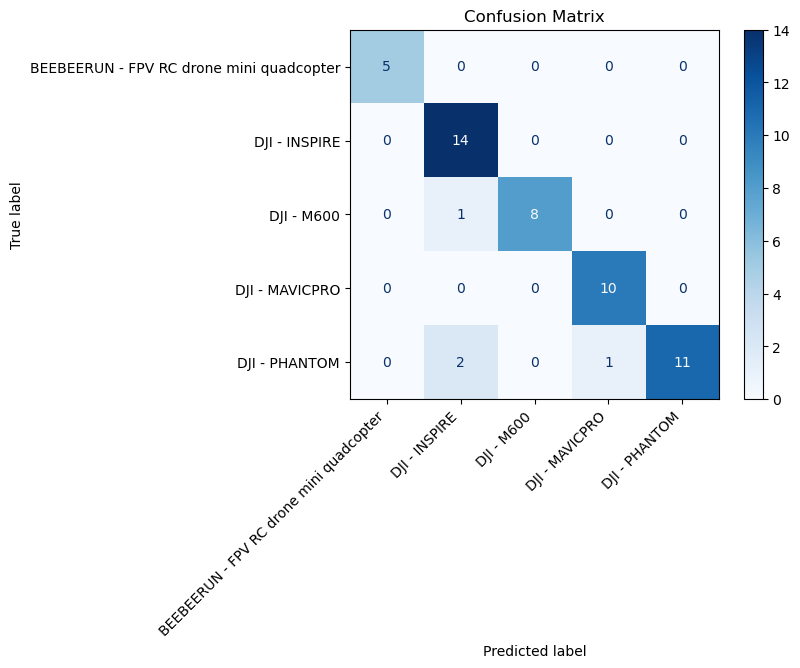

In [23]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()


Accuracy: 1.0
Classification Report:
                                          precision    recall  f1-score   support

BEEBEERUN - FPV RC drone mini quadcopter       1.00      1.00      1.00        20
                           DJI - INSPIRE       1.00      1.00      1.00        56
                              DJI - M600       1.00      1.00      1.00        36
                          DJI - MAVICPRO       1.00      1.00      1.00        40
                           DJI - PHANTOM       1.00      1.00      1.00        56

                                accuracy                           1.00       208
                               macro avg       1.00      1.00      1.00       208
                            weighted avg       1.00      1.00      1.00       208



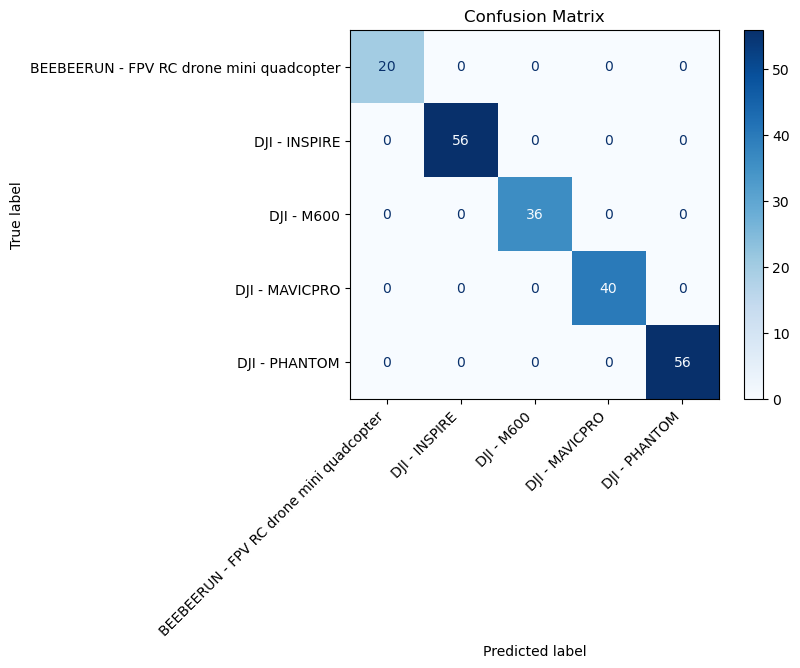

In [24]:
# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

### Display the tree

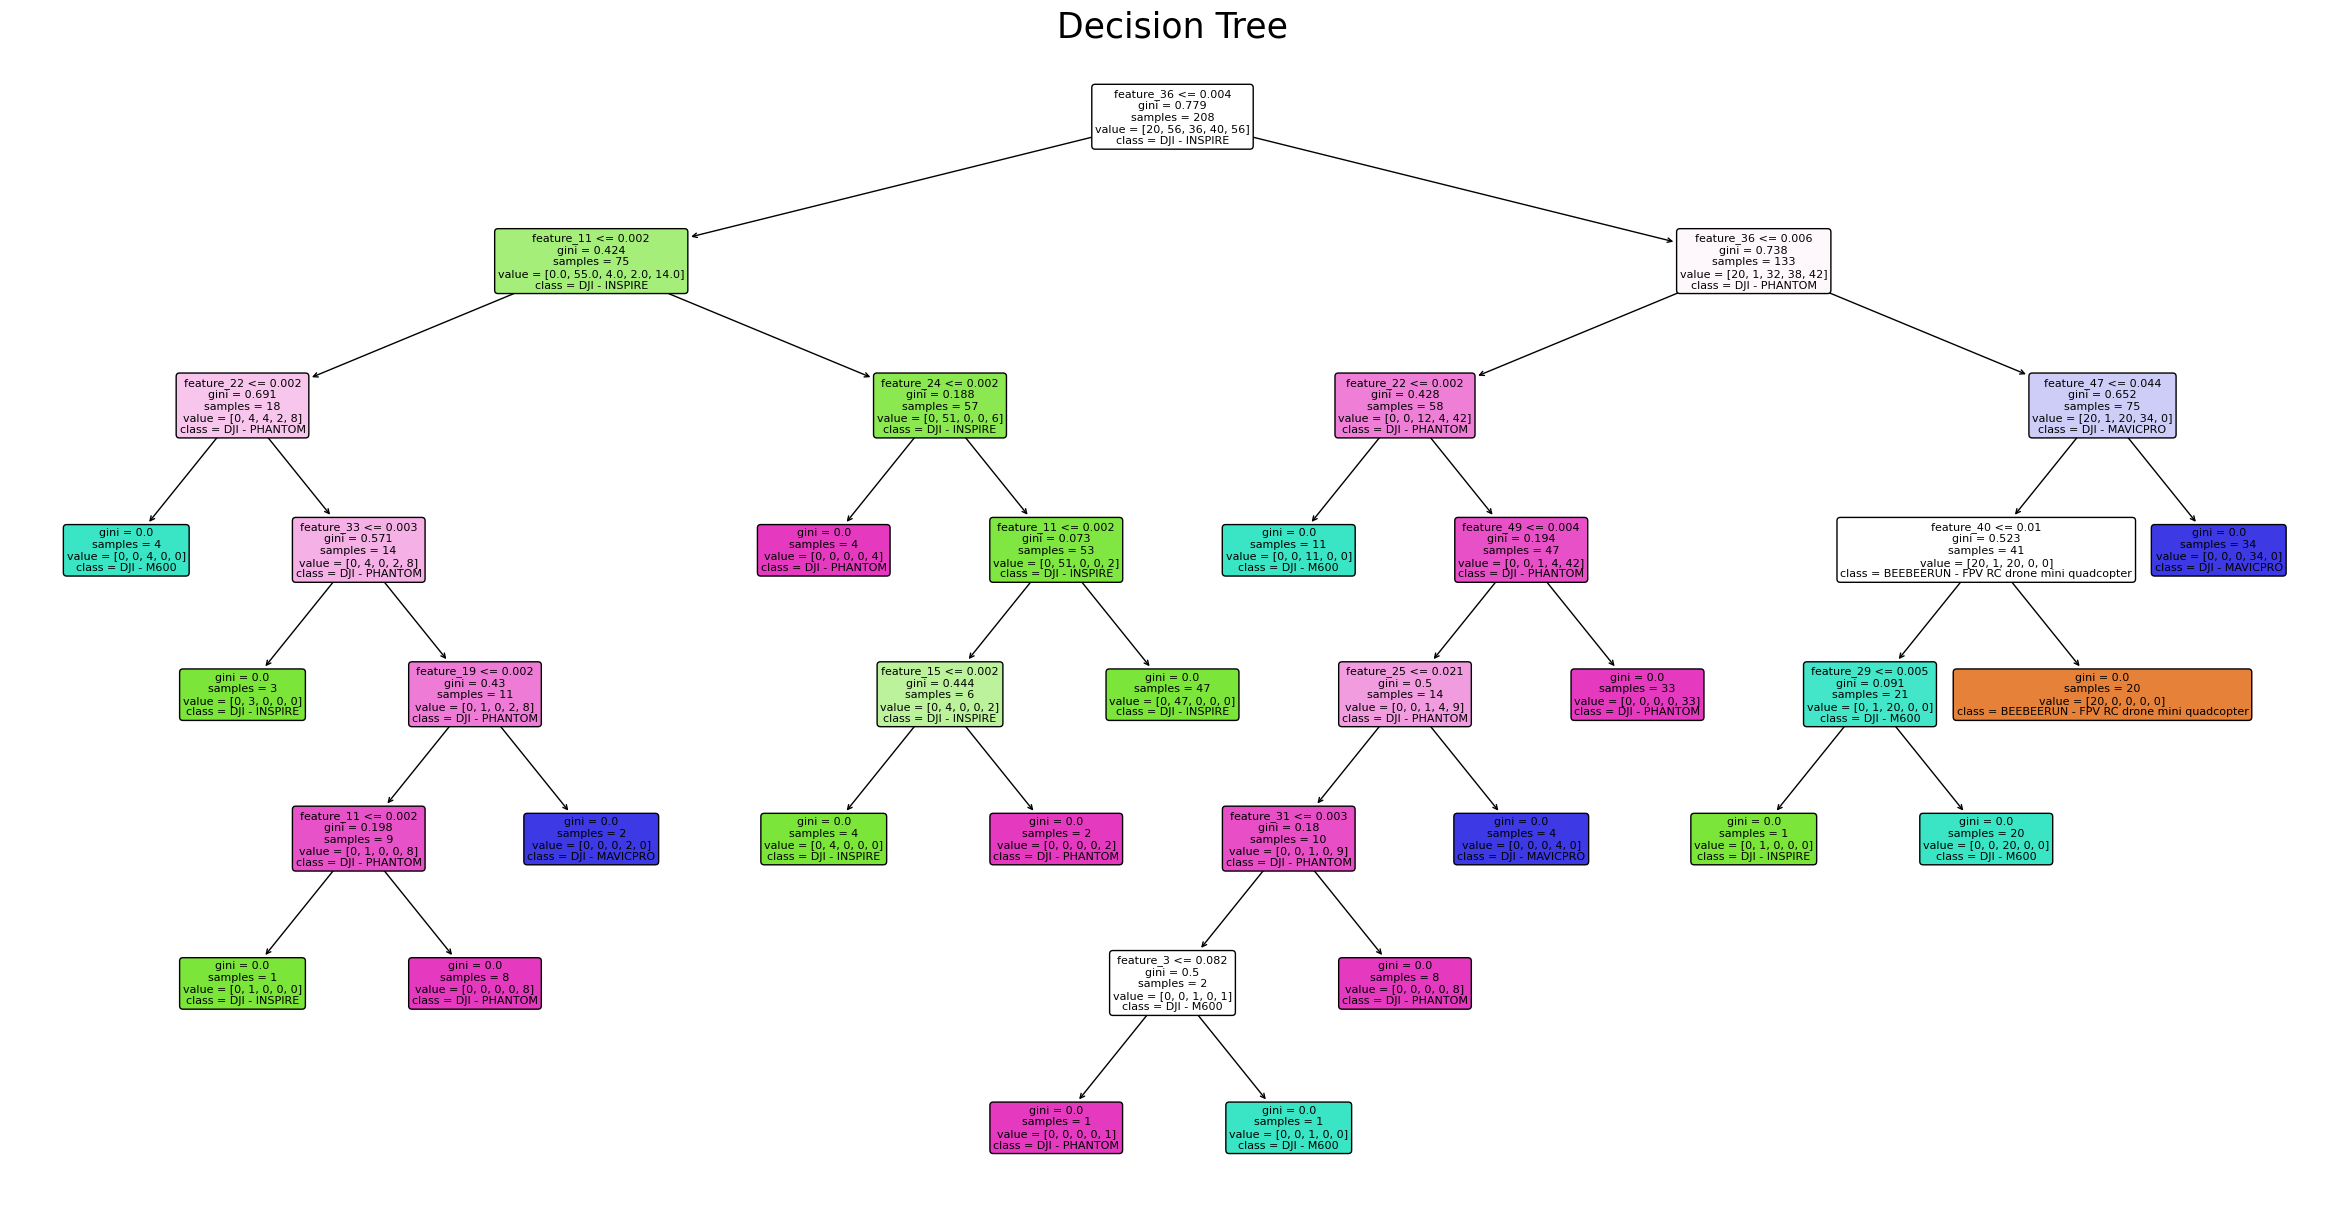

In [25]:
# Visualize the decision tree
plt.figure(figsize=(30, 15))
plot_tree(clf, feature_names=X_train.columns, class_names=label_encoder.classes_, filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree', fontsize=25)
plt.show()

Classify Activities

Train samples NLOS: (48, 11)
Test samples NLOS: (12, 11)
Train samples LOS: (160, 11)
Test samples LOS: (40, 11)
Accuracy: 0.8653846153846154
Classification Report:
                                               precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING       1.00      1.00      1.00         5
                           DJI_INSPIRE_FLYING       0.89      0.89      0.89         9
                         DJI_INSPIRE_VIDEOING       0.83      1.00      0.91         5
                              DJI_M600_FLYING       0.89      0.89      0.89         9
                          DJI_MAVICPRO_FLYING       1.00      1.00      1.00         5
                        DJI_MAVICPRO_HOVERING       1.00      1.00      1.00         5
                           DJI_PHANTOM_FLYING       0.71      0.56      0.62         9
                         DJI_PHANTOM_HOVERING       0.67      0.80      0.73         5

                                     accuracy     

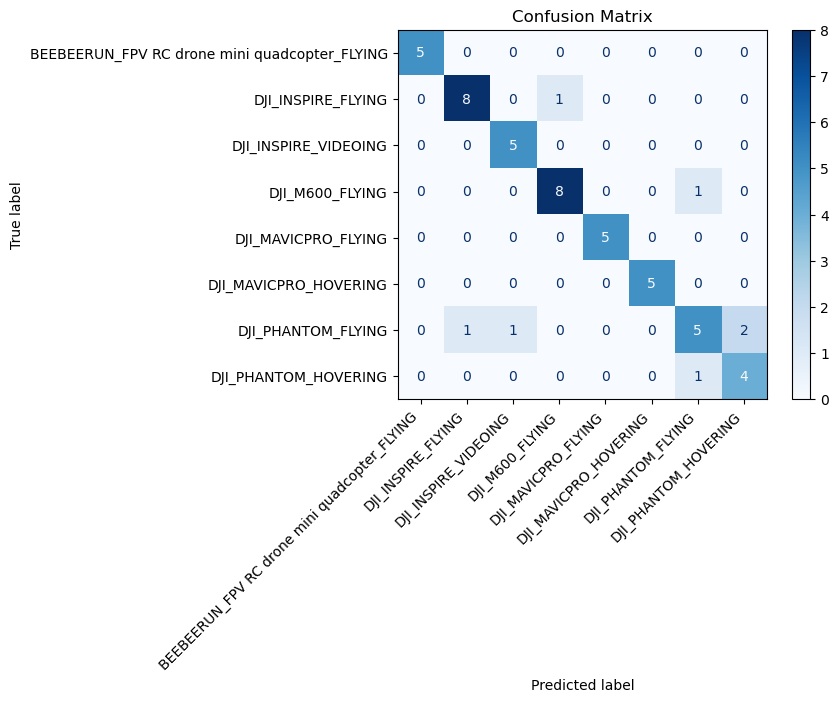

Accuracy: 1.0
Classification Report:
                                               precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING       1.00      1.00      1.00        20
                           DJI_INSPIRE_FLYING       1.00      1.00      1.00        36
                         DJI_INSPIRE_VIDEOING       1.00      1.00      1.00        20
                              DJI_M600_FLYING       1.00      1.00      1.00        36
                          DJI_MAVICPRO_FLYING       1.00      1.00      1.00        20
                        DJI_MAVICPRO_HOVERING       1.00      1.00      1.00        20
                           DJI_PHANTOM_FLYING       1.00      1.00      1.00        36
                         DJI_PHANTOM_HOVERING       1.00      1.00      1.00        20

                                     accuracy                           1.00       208
                                    macro avg       1.00      1.00      1.00       208
    

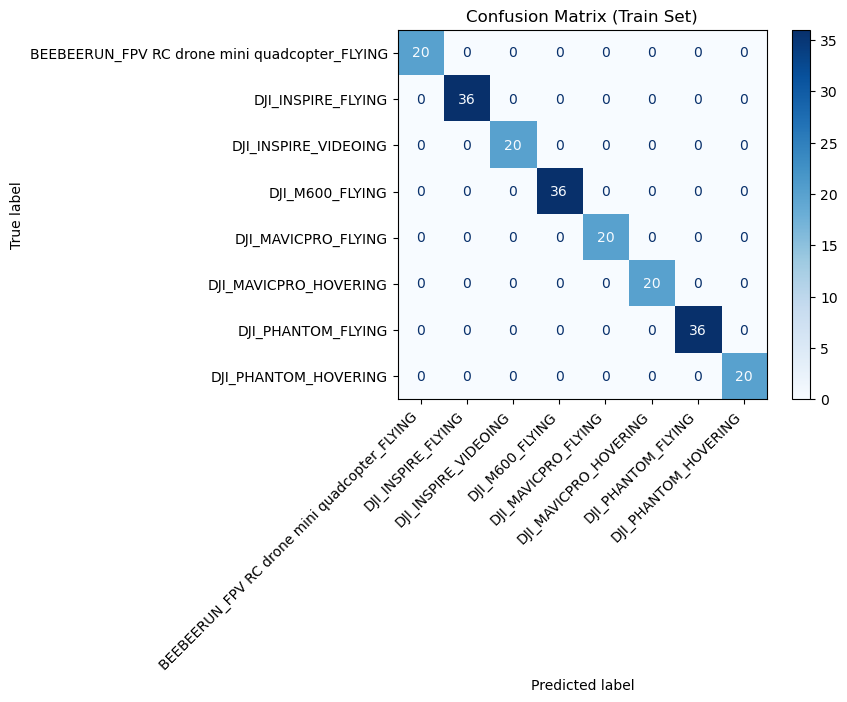

In [26]:
# Create a combined column for make, model, and activity
working_df['make_model_activity'] = working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity']

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to expand list column into multiple feature columns
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)

# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df_expanded['make_model_activity'] = label_encoder.fit_transform(train_df_expanded['make_model_activity'])
test_df_expanded['make_model_activity'] = label_encoder.transform(test_df_expanded['make_model_activity'])

# Split the data into features and target
X_train = train_df_expanded.drop('make_model_activity', axis=1)
y_train = train_df_expanded['make_model_activity']
X_test = test_df_expanded.drop('make_model_activity', axis=1)
y_test = test_df_expanded['make_model_activity']

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix for train set
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix for train set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

Classify NLOS and LOS

Train samples NLOS: (48, 12)
Test samples NLOS: (12, 12)
Train samples LOS: (160, 12)
Test samples LOS: (40, 12)
Accuracy: 0.8076923076923077
Classification Report:
                                                   precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING_LOS       1.00      1.00      1.00         5
                           DJI_INSPIRE_FLYING_LOS       0.56      1.00      0.71         5
                          DJI_INSPIRE_FLYING_NLOS       0.67      0.50      0.57         4
                         DJI_INSPIRE_VIDEOING_LOS       1.00      1.00      1.00         5
                              DJI_M600_FLYING_LOS       1.00      1.00      1.00         5
                             DJI_M600_FLYING_NLOS       0.67      0.50      0.57         4
                          DJI_MAVICPRO_FLYING_LOS       1.00      1.00      1.00         5
                        DJI_MAVICPRO_HOVERING_LOS       0.83      1.00      0.91         5
               

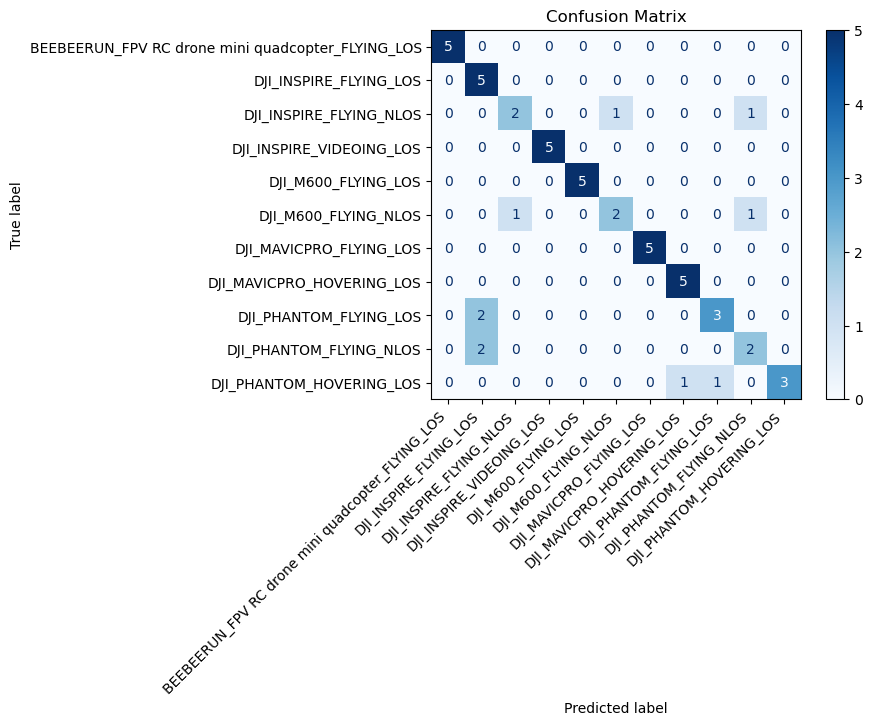

Accuracy: 1.0
Classification Report:
                                                   precision    recall  f1-score   support

BEEBEERUN_FPV RC drone mini quadcopter_FLYING_LOS       1.00      1.00      1.00        20
                           DJI_INSPIRE_FLYING_LOS       1.00      1.00      1.00        20
                          DJI_INSPIRE_FLYING_NLOS       1.00      1.00      1.00        16
                         DJI_INSPIRE_VIDEOING_LOS       1.00      1.00      1.00        20
                              DJI_M600_FLYING_LOS       1.00      1.00      1.00        20
                             DJI_M600_FLYING_NLOS       1.00      1.00      1.00        16
                          DJI_MAVICPRO_FLYING_LOS       1.00      1.00      1.00        20
                        DJI_MAVICPRO_HOVERING_LOS       1.00      1.00      1.00        20
                           DJI_PHANTOM_FLYING_LOS       1.00      1.00      1.00        20
                          DJI_PHANTOM_FLYING_NLOS   

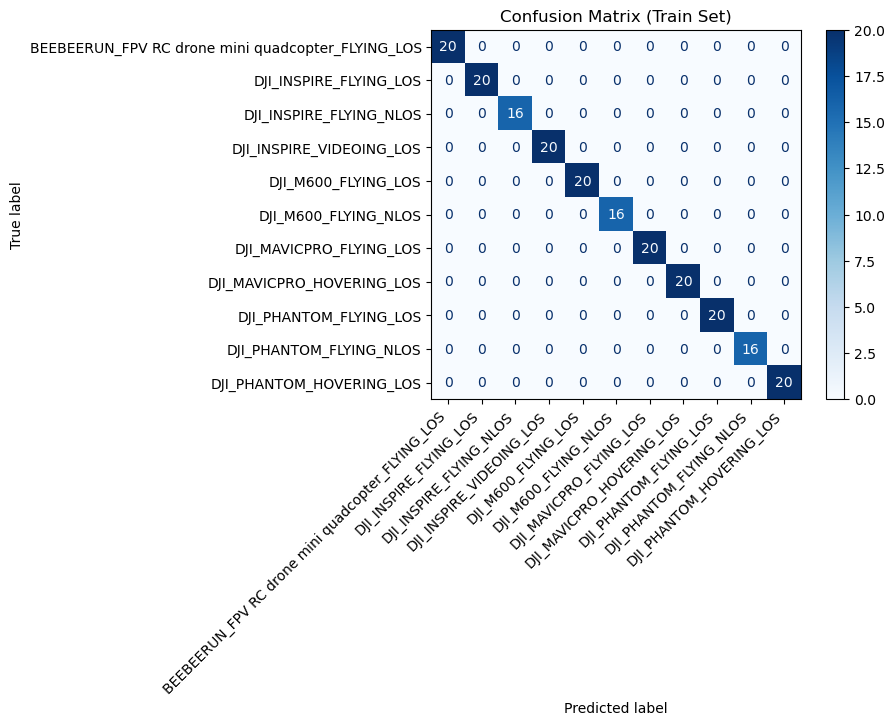

In [27]:
# Create a combined column for make, model, activity, and line_of_sight
working_df['make_model_activity_los'] = working_df['make'] + "_" + working_df['model'] + "_" + working_df['activity'] + "_" + working_df['line_of_sight']

# Filter NLOS data
nlos_df = working_df[working_df.line_of_sight == "NLOS"]

# Perform stratified split for NLOS
train_nlos_df, test_nlos_df = train_test_split(nlos_df, test_size=0.2, stratify=nlos_df['make_model_activity_los'], random_state=42)

print("Train samples NLOS:", train_nlos_df.shape)
print("Test samples NLOS:", test_nlos_df.shape)

# Split the samples for LOS
train_los_df = working_df[working_df.train_test == "Train"]
test_los_df = working_df[working_df.train_test == "Test"]

print("Train samples LOS:", train_los_df.shape)
print("Test samples LOS:", test_los_df.shape)

# Concatenate LOS and NLOS data
train_df = pd.concat([train_los_df, train_nlos_df], ignore_index=True)
test_df = pd.concat([test_los_df, test_nlos_df], ignore_index=True)

# Select only needed columns
sel_col = ['make_model_activity_los', 'cwt_coeffs']
train_df = train_df[sel_col]
test_df = test_df[sel_col]

# Function to expand list column into multiple feature columns
def expand_list_column(df, list_col, new_cols):
    if df[list_col].apply(len).max() > len(new_cols):
        raise ValueError("The number of new columns must be at least as many as the longest list in the column.")
    for i, col_name in enumerate(new_cols):
        df[col_name] = df[list_col].apply(lambda x: x[i] if i < len(x) else None)
    return df

new_columns = [f'feature_{i}' for i in range(1, 51)]
train_df_expanded = expand_list_column(train_df, 'cwt_coeffs', new_columns)
test_df_expanded = expand_list_column(test_df, 'cwt_coeffs', new_columns)
train_df_expanded.drop(columns="cwt_coeffs", inplace=True)
test_df_expanded.drop(columns="cwt_coeffs", inplace=True)

# Convert string labels to numerical values
label_encoder = LabelEncoder()
train_df_expanded['make_model_activity_los'] = label_encoder.fit_transform(train_df_expanded['make_model_activity_los'])
test_df_expanded['make_model_activity_los'] = label_encoder.transform(test_df_expanded['make_model_activity_los'])

# Split the data into features and target
X_train = train_df_expanded.drop('make_model_activity_los', axis=1)
y_train = train_df_expanded['make_model_activity_los']
X_test = test_df_expanded.drop('make_model_activity_los', axis=1)
y_test = test_df_expanded['make_model_activity_los']

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

# Make predictions on the train set
y_pred_train = clf.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_pred_train)
report = classification_report(y_train, y_pred_train, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Generate the confusion matrix for train set
cm = confusion_matrix(y_train, y_pred_train)

# Plot the confusion matrix for train set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Train Set)')
plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
train_df.shape

(208, 51)

In [29]:
test_df.shape

(52, 51)